<a href="https://colab.research.google.com/github/kalathomas083/thinkful-capstone/blob/master/Heart_Disease_Predictive_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Introduction

Heart disease is the leading cause of death in the US. One person dies every 37 seconds in the United States from cardiovascular disease. Often people are aware they are at risk, however this isn't always the case. There is more that can be done with data to help identify people at risk. 

# 2. Hypothesis

Predictive modeling can be used to determine if a person is at risk using data from various physical tests.

# 3. Data
The data has 14 data points from 303 participants.

https://www.kaggle.com/nareshbhat/health-care-data-set-on-heart-attack-possibility

## Attribute Information
1. age
2. sex
3. chest pain type (4 values)
4. resting blood pressure
5. serum cholesterol in mg/dl
6. fasting blood sugar > 120 mg/dl
7. resting electrocardiographic results (values 0,1,2)
8. maximum heart rate achieved
9. exercise induced angina
10. oldpeak = ST depression induced by exercise relative to rest
11. the slope of the peak exercise ST segment
12. number of major vessels (0-3) colored by fluoroscopy
13. thal: 0 = normal; 1 = fixed defect; 2 = reversable defect
14. target: 0= less chance of heart attack 1= more chance of heart attack

# 4. Model creation

## Data preparation

### Imports

In [ ]:
## imports
import pandas as pd #needed for dataframes
%load_ext google.colab.data_table
import numpy as np 
import matplotlib.pyplot as plt #needed for graphs
import seaborn as sns #needed for graphs
import math #for floor/ceil and other math functions
from scipy import stats #for stats functions
%matplotlib inline
sns.set(style="whitegrid")

from sklearn.preprocessing import normalize
from scipy.stats.mstats import winsorize

# Feature engineering
from sklearn.preprocessing import StandardScaler #for PCA
from sklearn.decomposition import PCA #for PCA

# Regression
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression, LinearRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split #for creating train/test
from sklearn.metrics import confusion_matrix

## testing tools for model success
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse 

# Similarity models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn import ensemble
import itertools


The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


In [ ]:
df = pd.read_csv('/content/drive/My Drive/Thinkful/Homework Assignments/Capstone 2/heart.csv')
target = 'target'

### Univariate Analysis

#### How many variables to I have?

In [ ]:
df.shape

(303, 14)

Looks like there are 14 different features with 303 different samples

In [ ]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [ ]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


#### Do I have missing data?

In [ ]:
# Find missing values count
def get_missing(df = df):
  # get count of missing values
  total_missing = df.isnull().sum().sort_values(ascending=False)

  # get percent of missing values
  percent_missing = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)

  # combine data into frame
  missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'])
  
  # show the data
  missing_number = len(df.loc[:, df.isna().any()].columns)
  print("{} columns have missing values \n\nThey are:".format(missing_number))
  print(missing_data.head(missing_number))

  # create list of all columns with missing values
  full_list = list(df.loc[:, df.isna().any()].columns)

  # create list of columns to interpolate
  interpolate_df = missing_data.loc[(missing_data['Percent'] < .2) & (missing_data['Percent'] > 0)]
  interpolate_list = interpolate_df.index.tolist()

  drop_df = missing_data.loc[(missing_data['Percent'] > .8)]
  drop_list = drop_df.index.tolist()
  
  return full_list, interpolate_list, drop_list

all_missing, interpolate, drop = get_missing()

0 columns have missing values 

They are:
Empty DataFrame
Columns: [Total, Percent]
Index: []


No missing data

#### What types of variables do I have?

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


All the columns appear to be numerical. All but one appears to be integers

In [ ]:
# Look at the number of unique values for each column
df.nunique()

age          41
sex           2
cp            4
trestbps     49
chol        152
fbs           2
restecg       3
thalach      91
exang         2
oldpeak      40
slope         3
ca            5
thal          4
target        2
dtype: int64

In [ ]:
# Find list of columns with numeric values
num_col = list(df.select_dtypes(['int64', 'float64']).columns)
print("The number of numerical columns is {}".format(len(num_col)))
num_col

The number of numerical columns is 14


['age',
 'sex',
 'cp',
 'trestbps',
 'chol',
 'fbs',
 'restecg',
 'thalach',
 'exang',
 'oldpeak',
 'slope',
 'ca',
 'thal',
 'target']

### Multivariate Analysis

#### Distribution

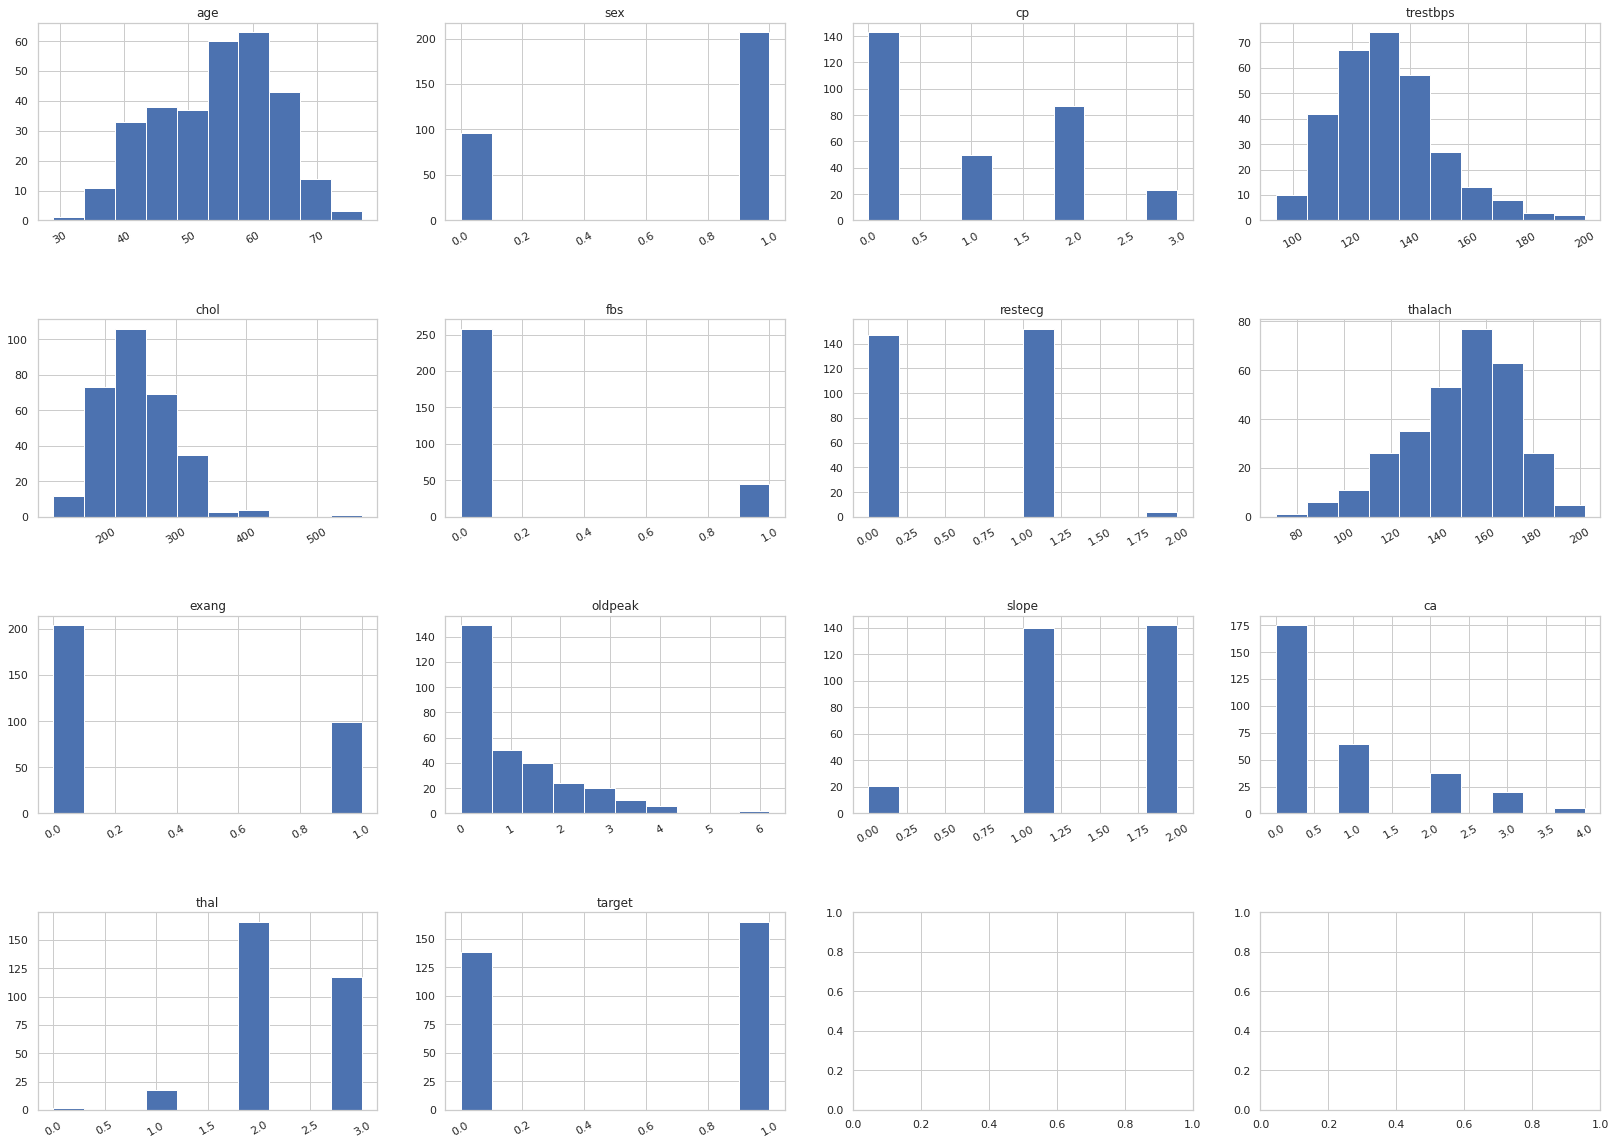

In [ ]:
# Function to create a grid of histogram plots
def hist_loop(columns_list=None, df=df):
  if columns_list == None:
    # Create column list
    columns_list = df.columns.tolist()

  # Determine number of columns for subplot
  if len(columns_list) % 5 == 0:
    ncols = 5
  elif len(columns_list) % 4 == 0:
    ncols = 4
  elif len(columns_list) % 3 == 0:
    ncols = 3
  else:
    ncols = 4

  # Calculate number of rows for subplot
  nrows = int(math.ceil(len(columns_list) / ncols))

  # Create subplot and determine size
  fig, axs = plt.subplots(nrows, ncols)
  fig.set_size_inches(7 * ncols, 5 * nrows)
  fig.subplots_adjust(wspace=0.2)
  fig.subplots_adjust(hspace=0.5)

  # Loop through columns to create each individual plot
  for column, ax in zip(columns_list, axs.flatten()):
    ax.hist(df[column])
    ax.set_title(column)
    ax.tick_params(axis='x', labelrotation=30)

# Call function and create boxplots
hist_loop(num_col)

#### Correlation 

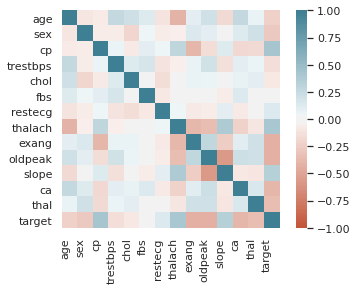

In [ ]:
# Create a correlation table for all variables
corr = df.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
);

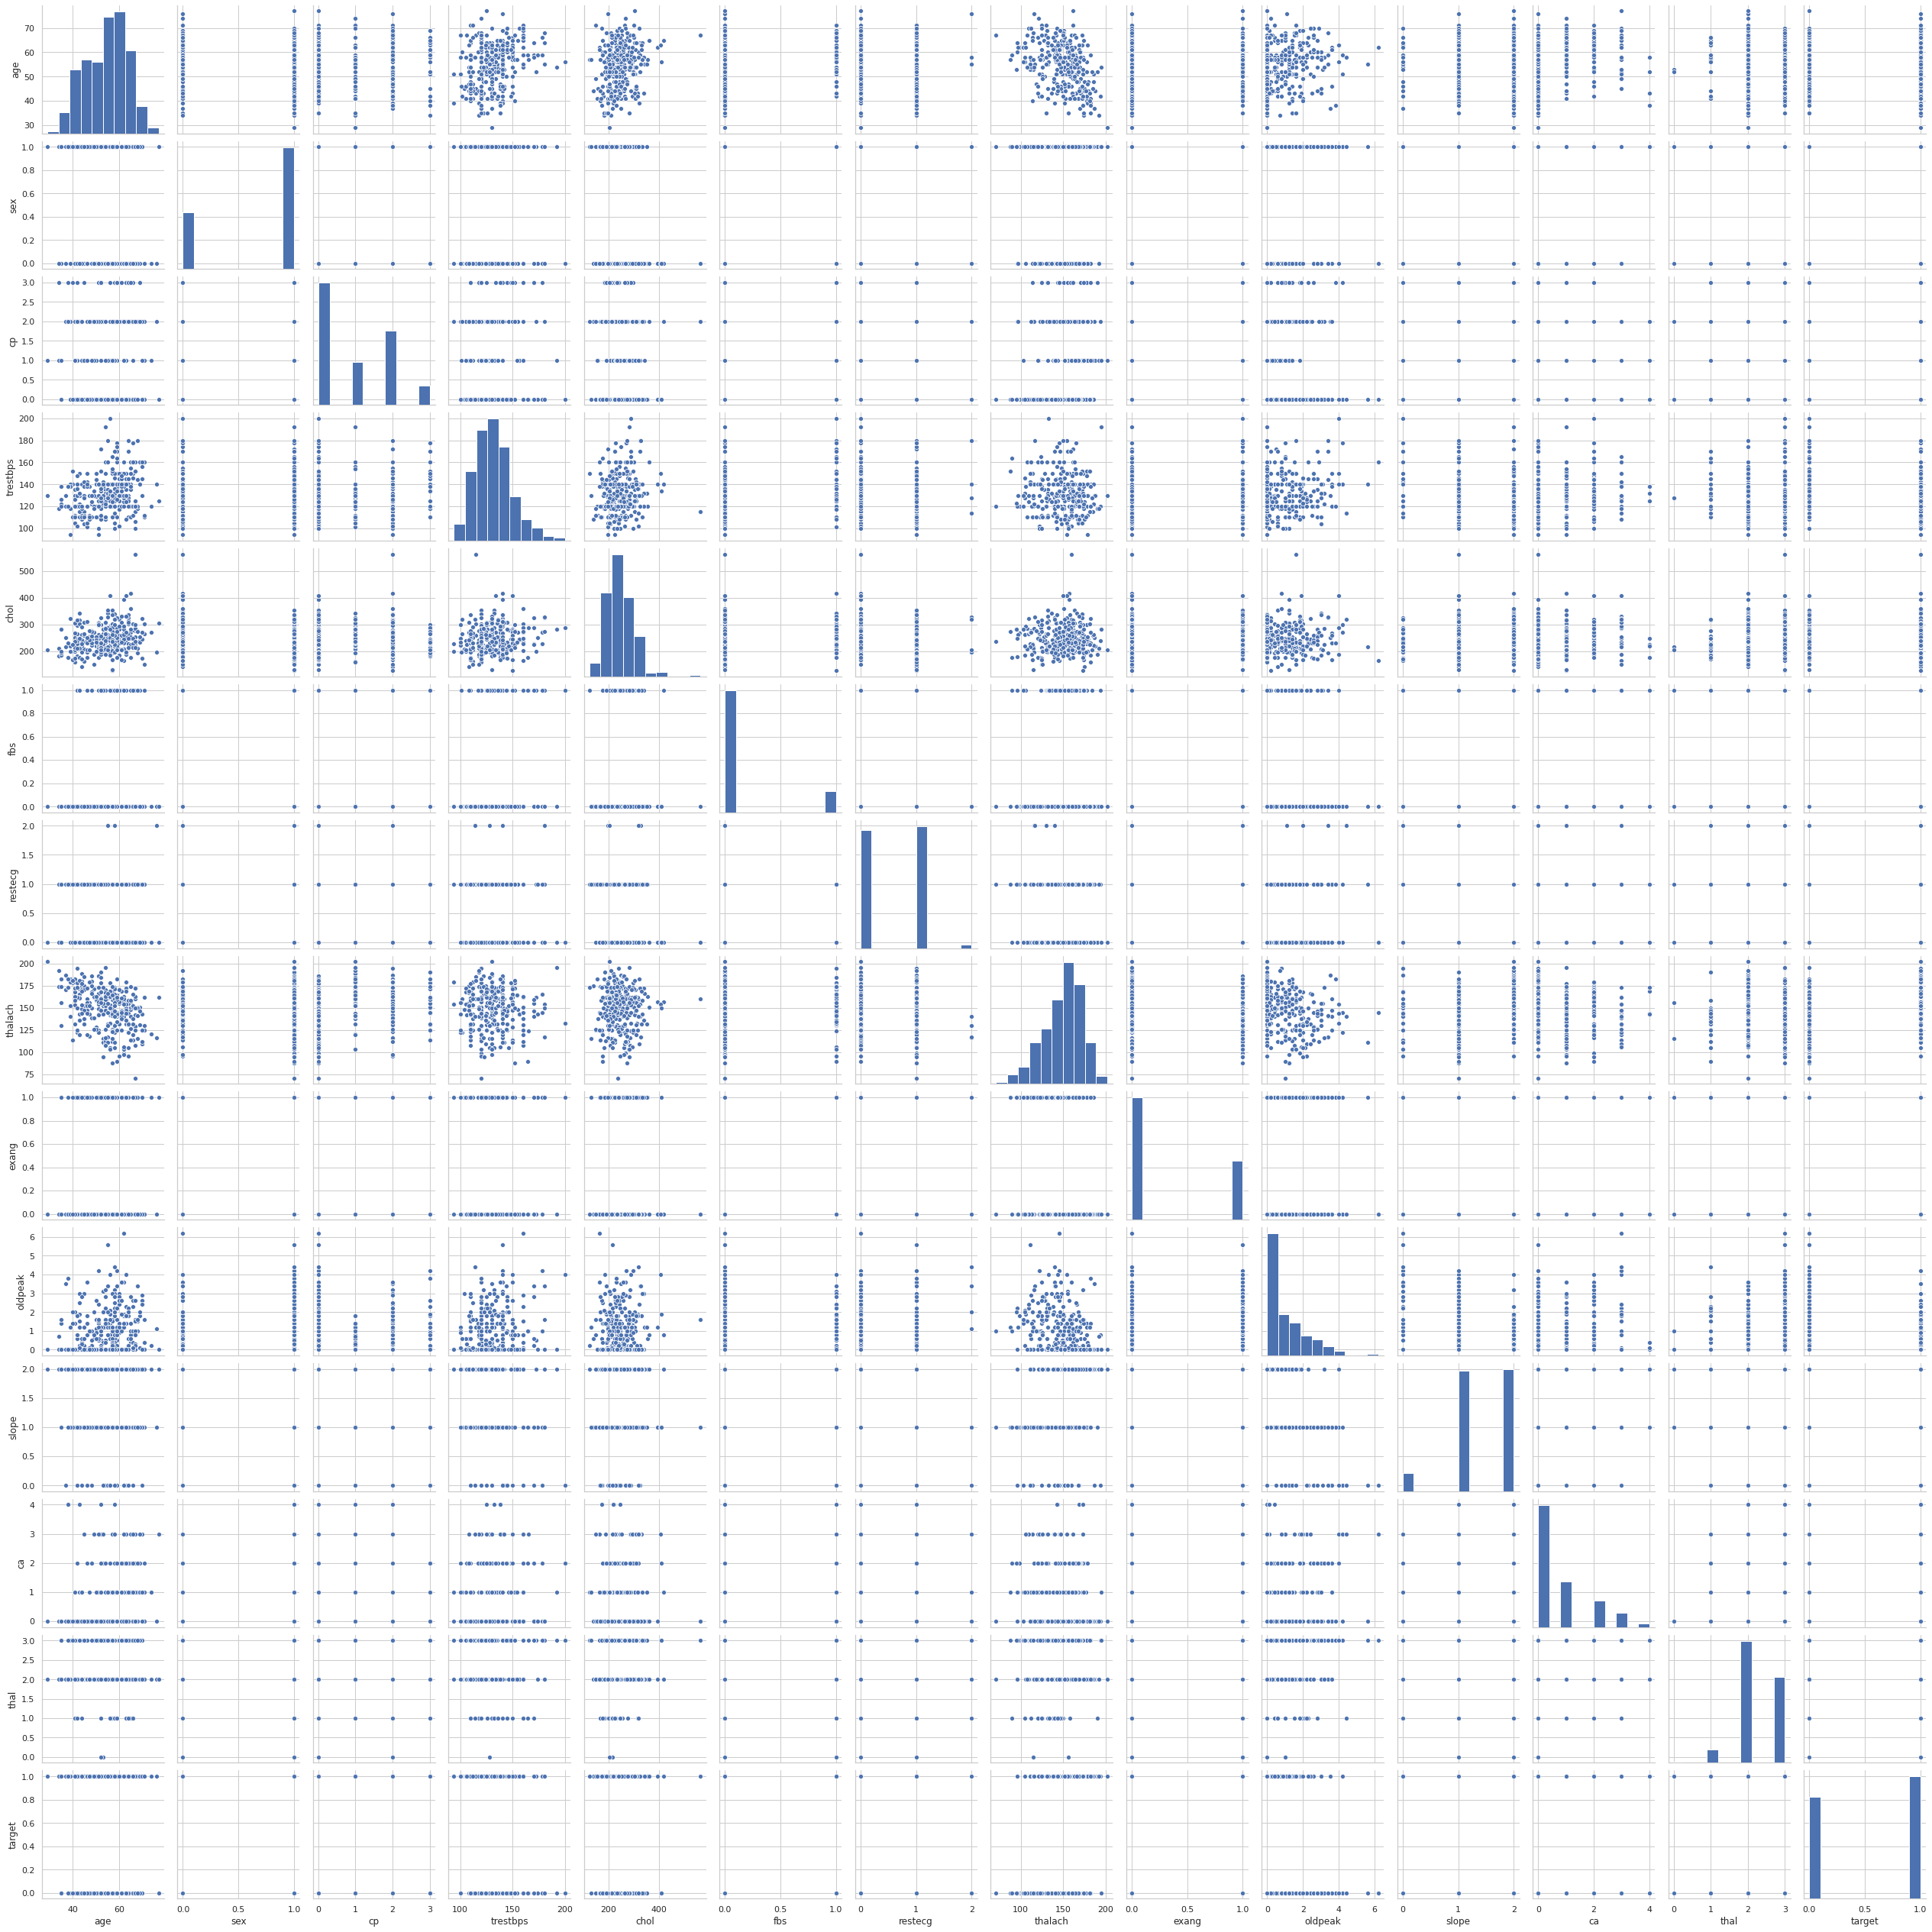

In [ ]:
sns.pairplot(df)

### Cleaning

#### Missing data

Because there are no missing values, I'll continue on to outliers.

#### Outliers

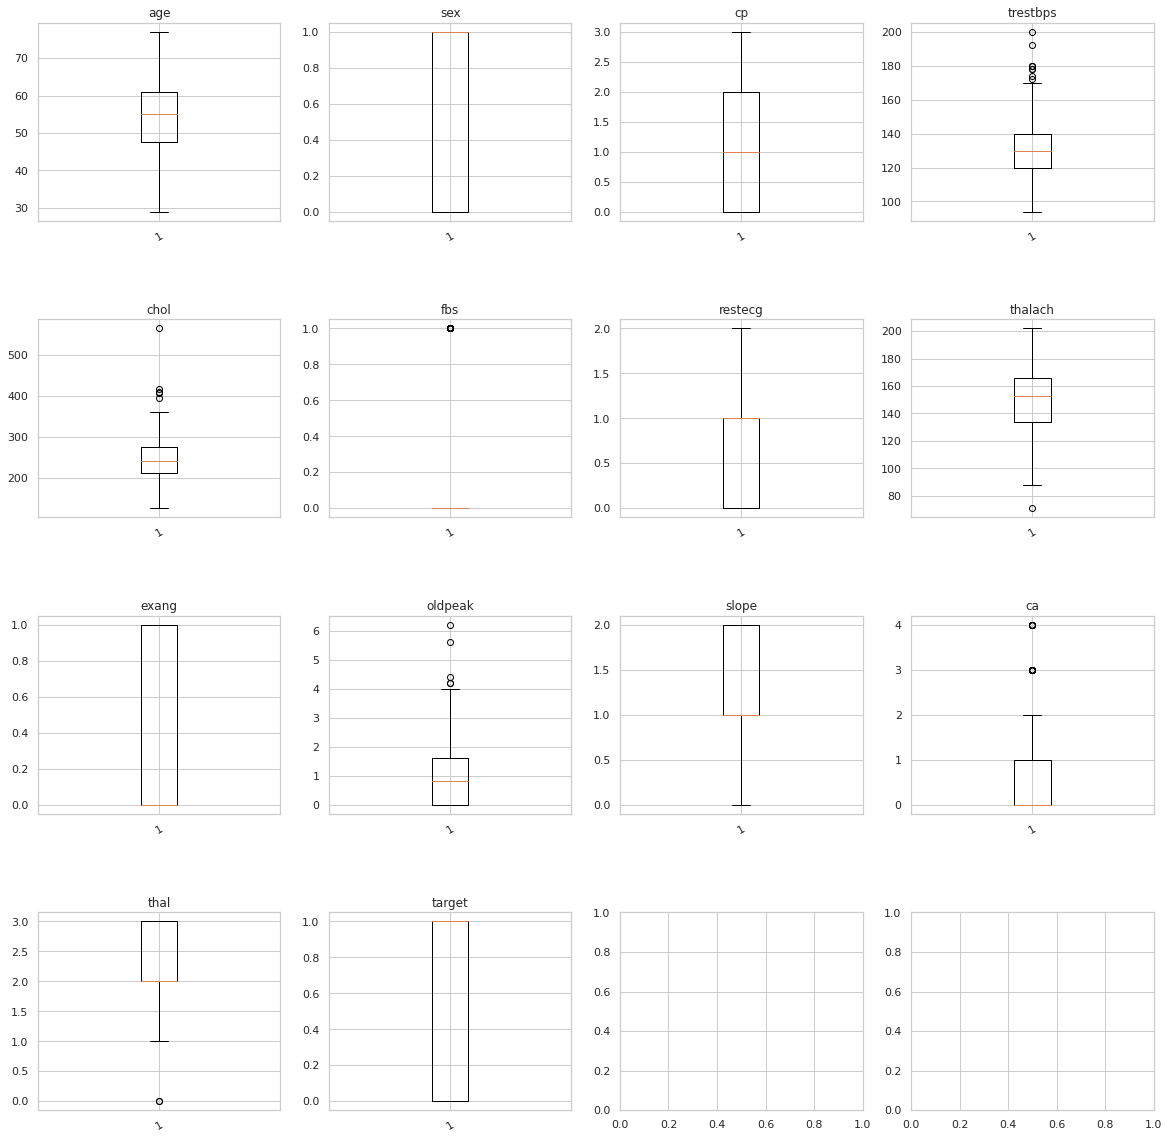

In [ ]:
def boxplot_loop(df=df, columns_list = None):
  if columns_list == None:
    # Create column list
    columns_list = df.columns.tolist()
  
  # Create column list
  columns_list = df.columns.tolist()

  # Determine number of columns for subplot
  if len(columns_list) % 5 == 0:
    ncols = 5
  elif len(columns_list) % 4 == 0:
    ncols = 4
  elif len(columns_list) % 3 == 0:
    ncols = 3
  else:
    ncols = 4

  # Calculate number of rows for subplot
  nrows = int(math.ceil(len(columns_list) / ncols))

  # Create subplot and determine size
  fig, axs = plt.subplots(nrows, ncols)
  fig.set_size_inches(5 * ncols, 5 * nrows)
  fig.subplots_adjust(wspace=0.2)
  fig.subplots_adjust(hspace=0.5)

  # Loop through columns to create each individual plot
  for column, ax in zip(columns_list, axs.flatten()):
    dftemp = df[column].value_counts()
    ax.boxplot(df[column])
    ax.set_title(column)
    ax.tick_params(axis='x', labelrotation=30)

# Call function and create boxplots
boxplot_loop()

In [ ]:
def do_tukeys(df=df):
  columns_list = [key for key in dict(df.dtypes) if dict(df.dtypes)[key] in ['float64', 'int64']]
  columns_list.remove(target)

  for column in columns_list:
    q75, q25 = np.percentile(df[column], [75 ,25])
    iqr = q75 - q25

    for threshold in np.arange(2,3,0.5):
        min_val = q25 - (iqr*threshold)
        max_val = q75 + (iqr*threshold)
        if len((np.where((df[column] > max_val) | (df[column] < min_val))[0])) > 0:
          print(column)
          print("The score threshold is: {}".format(threshold))
          print("Number of outliers is: {}".format(
              len((np.where((df[column] > max_val) 
                            | (df[column] < min_val))[0]))
          ),'\n\n')

do_tukeys()

trestbps
The score threshold is: 2.0
Number of outliers is: 2 


trestbps
The score threshold is: 2.5
Number of outliers is: 2 


chol
The score threshold is: 2.0
Number of outliers is: 4 


chol
The score threshold is: 2.5
Number of outliers is: 1 


fbs
The score threshold is: 2.0
Number of outliers is: 45 


fbs
The score threshold is: 2.5
Number of outliers is: 45 


oldpeak
The score threshold is: 2.0
Number of outliers is: 2 


oldpeak
The score threshold is: 2.5
Number of outliers is: 1 


ca
The score threshold is: 2.0
Number of outliers is: 5 


ca
The score threshold is: 2.5
Number of outliers is: 5 




Outliers aren't a problem here so I will take no action.

### Feature creation
I opted to create a feature that represents the interaction of sex and age.

In [ ]:
df['age_sex'] = df.age * df.sex
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
 14  age_sex   303 non-null    int64  
dtypes: float64(1), int64(14)
memory usage: 35.6 KB


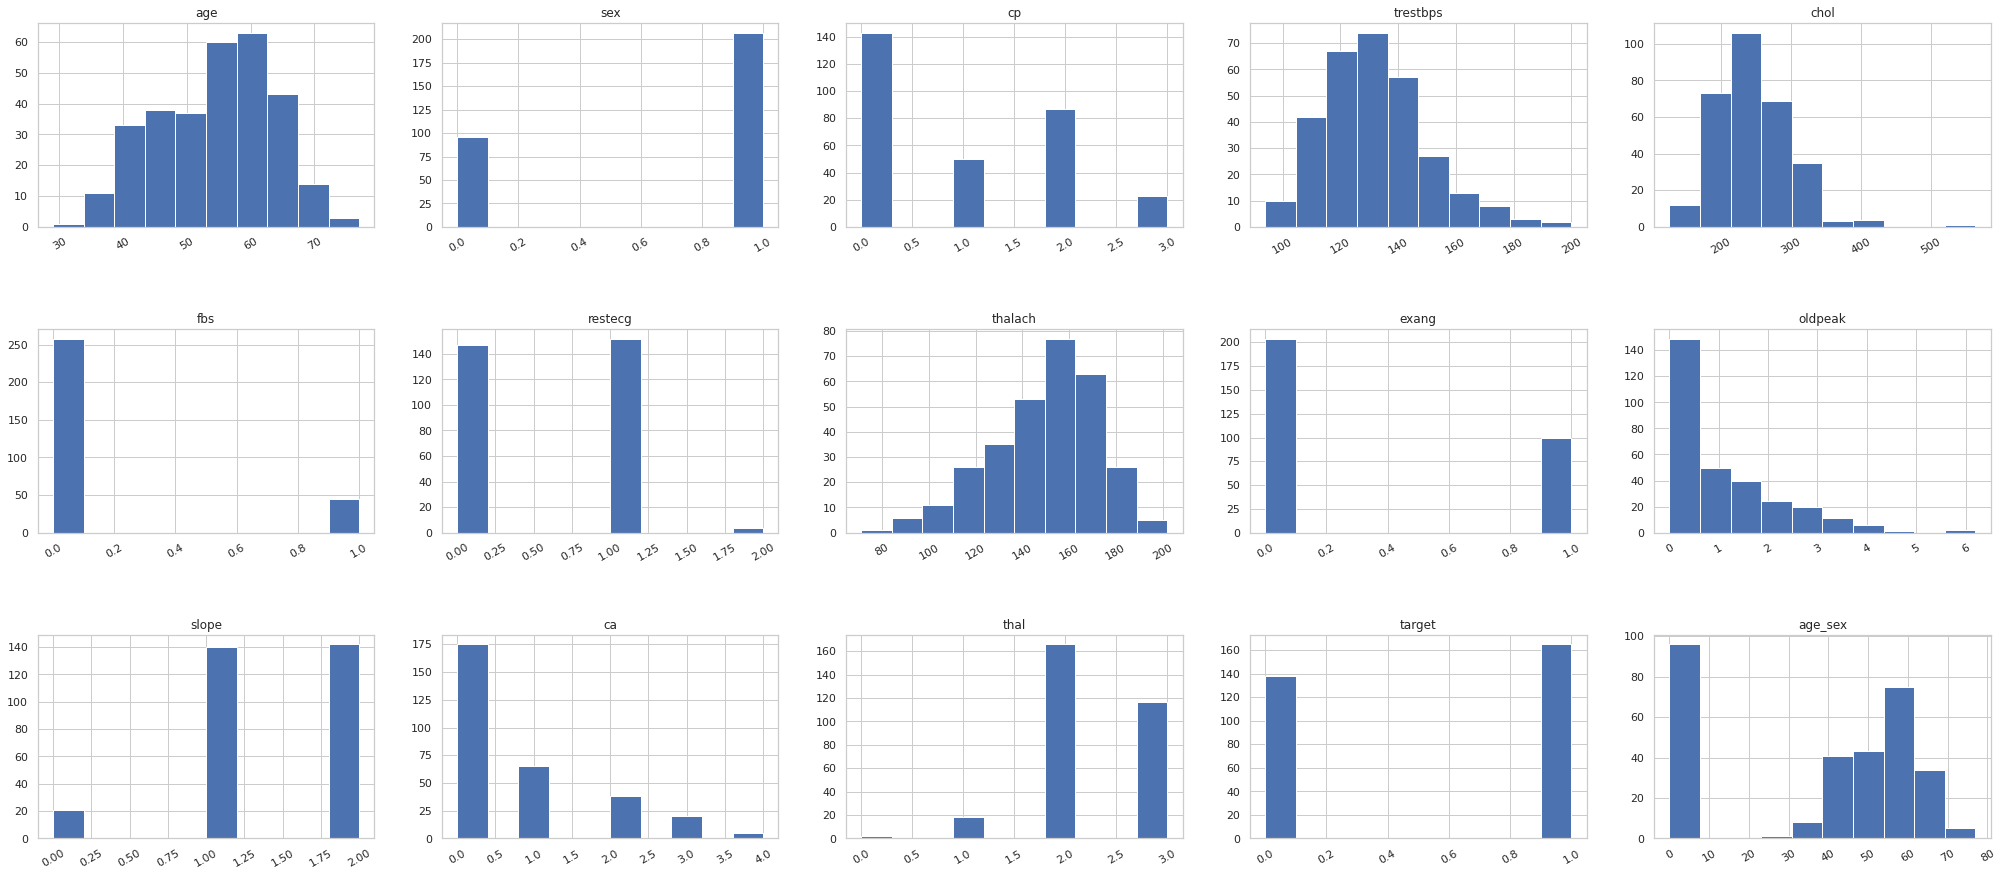

In [ ]:
def hist_loop(df=df, columns_list=None):
  if columns_list == None:
    # Create column list
    columns_list = df.columns.tolist()

  # Determine number of columns for subplot
  if len(columns_list) % 5 == 0:
    ncols = 5
  elif len(columns_list) % 4 == 0:
    ncols = 4
  elif len(columns_list) % 3 == 0:
    ncols = 3
  else:
    ncols = 4

  # Calculate number of rows for subplot
  nrows = int(math.ceil(len(columns_list) / ncols))

  # Create subplot and determine size
  fig, axs = plt.subplots(nrows, ncols)
  fig.set_size_inches(7 * ncols, 5 * nrows)
  fig.subplots_adjust(wspace=0.2)
  fig.subplots_adjust(hspace=0.5)

  # Loop through columns to create each individual plot
  for column, ax in zip(columns_list, axs.flatten()):
    ax.hist(df[column])
    ax.set_title(column)
    ax.tick_params(axis='x', labelrotation=30)

# Call function and create boxplots
hist_loop()

In [ ]:
# Look at the correlation between target and other variables
num_col = list(df.select_dtypes(['int64', 'float64']).columns) #find the columns with numbers
correlation = np.abs(df[num_col].iloc[:,1:].corr().loc[:,target]).sort_values(ascending=False) # correlation table
corr_keepers = correlation.loc[(correlation > .3)].index.values.tolist()[1:] # the values over my chosen threshold for this data set
print(correlation)
print(corr_keepers)

target      1.000000
exang       0.436757
cp          0.433798
oldpeak     0.430696
thalach     0.421741
ca          0.391724
slope       0.345877
thal        0.344029
age_sex     0.337133
sex         0.280937
trestbps    0.144931
restecg     0.137230
chol        0.085239
fbs         0.028046
Name: target, dtype: float64
['exang', 'cp', 'oldpeak', 'thalach', 'ca', 'slope', 'thal', 'age_sex']


## Model option 1

Going to try the different classification model options on the full data set to see how it performs.

In [ ]:
# Create X and Y with values for the full set
X = df.loc[:, df.columns != target]
Y = df[target]

In [ ]:
# Test train split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

### Logistic regression

In [ ]:
lr = LogisticRegression(solver='liblinear', penalty='l1', random_state=2, max_iter=1000)

In [ ]:
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=2, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
lr_score1 = lr.score(X_test, y_test)
lr_cv_score1 = cross_val_score(lr, X, Y, cv=10)
print(lr_score1)
print(lr_cv_score1)

0.8131868131868132
[0.87096774 0.77419355 0.83870968 0.86666667 0.9        0.76666667
 0.86666667 0.86666667 0.7        0.7       ]


The score for logistic regression is good! Still want to examine other options.

### KNN

In [ ]:
neighbors = KNeighborsClassifier(n_neighbors=3)
neighbors.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [ ]:
knn_pred1 = neighbors.predict(X_test)
knn_score1 = neighbors.score(X_test, y_test)
knn_cv_score1 = cross_val_score(neighbors,X,Y,cv=10)

print(knn_score1)
print(knn_cv_score1)

0.7472527472527473
[0.77419355 0.67741935 0.70967742 0.63333333 0.76666667 0.7
 0.73333333 0.73333333 0.66666667 0.76666667]


[[30 11]
 [12 38]]


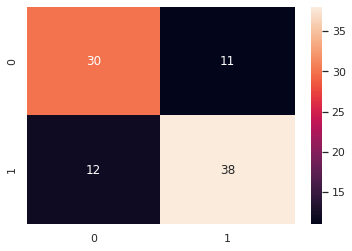

In [ ]:
y_pred = pd.DataFrame(neighbors.predict(X_test))
cm = confusion_matrix(y_test, y_pred)
# print(y_test)
print(cm)
sns.heatmap(cm, annot=True)
plt.show()

The model performs relatively well.

### Decision Tree

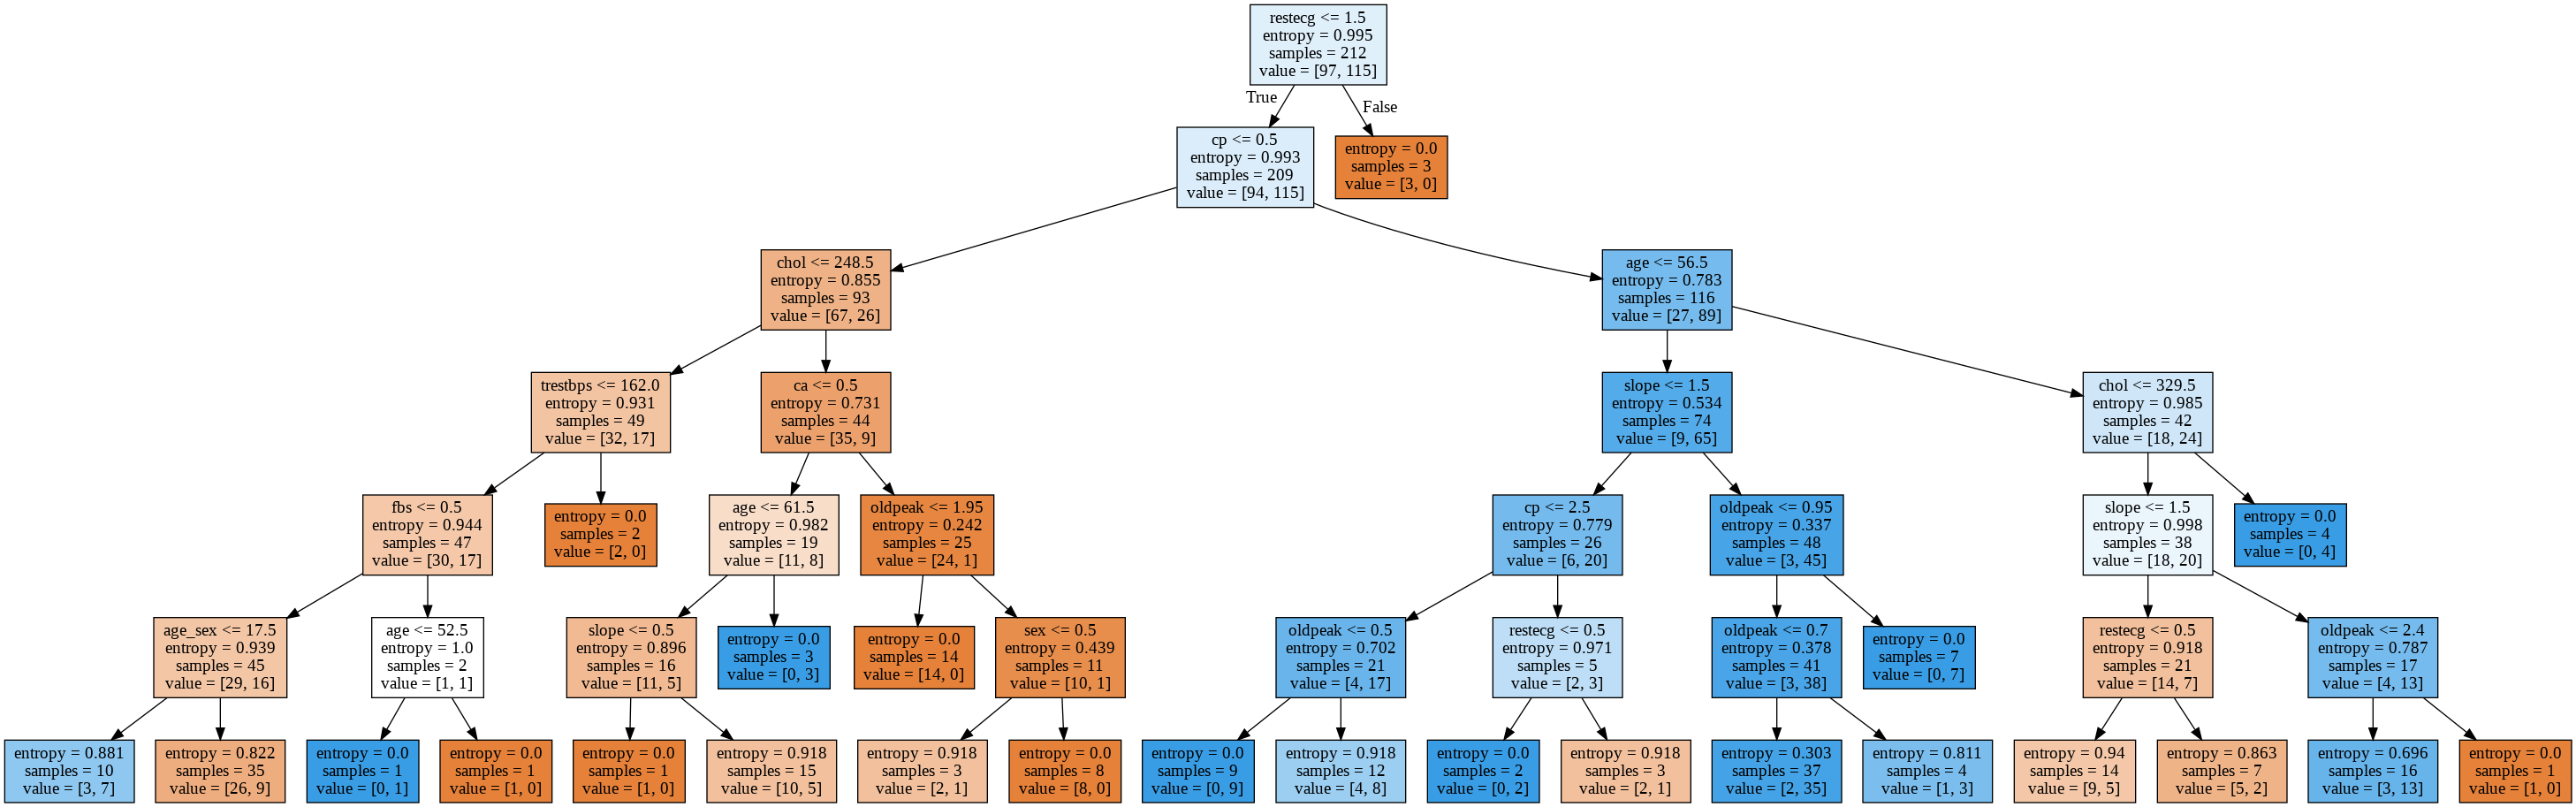

In [ ]:
# This is the model we'll be using.
from sklearn import tree

# A convenience for displaying visualizations.
from IPython.display import Image

# Packages for rendering our tree.
import pydotplus
import graphviz

# Initialize and train our tree.
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=1,
    max_depth=6,
    random_state = 1337
)
decision_tree.fit(X_train, y_train)

# Render our tree.
dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=X.columns,
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [ ]:
feat_importance = decision_tree.tree_.compute_feature_importances(normalize=False)
feat_imp_dict = dict(zip(X.columns, decision_tree.feature_importances_))
feat_imp = pd.DataFrame.from_dict(feat_imp_dict, orient='index')
feat_imp.rename(columns = {0:'FeatureImportance'}, inplace = True)
feat_imp.sort_values(by=['FeatureImportance'], ascending=False).head()

,FeatureImportance
cp,0.385271
age,0.165287
oldpeak,0.090821
slope,0.090488
ca,0.075846


In [ ]:
dt_score1 = decision_tree.score(X_test, y_test)
dt_cv_score1 = cross_val_score(decision_tree, X, Y, cv=10)
print(dt_score1)
print(dt_cv_score1)

0.7252747252747253
[0.77419355 0.70967742 0.74193548 0.73333333 0.86666667 0.63333333
 0.66666667 0.8        0.66666667 0.66666667]


### Boosting

In [ ]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.

# *** It's best to update this table for the drill 
#  at the end of the lesson.  ***

params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

In [ ]:
def plot_confusion_matrix(cm, classes,normalize,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center", verticalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


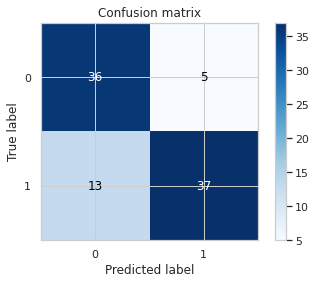

In [ ]:
cm = confusion_matrix(y_test, predict_test)
plot_confusion_matrix(cm,[0,1],False)

Normalized confusion matrix


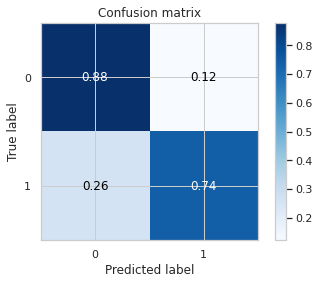

In [ ]:
cm = confusion_matrix(y_test, predict_test)
plot_confusion_matrix(cm,[0,1],True)

In [ ]:
boost_score1 = clf.score(X_test, y_test)
boost_cv_score1 = cross_val_score(clf, X, Y, cv=10)
print(boost_score1)
print(boost_cv_score1)

0.8021978021978022
[0.77419355 0.83870968 0.83870968 0.9        0.9        0.63333333
 0.76666667 0.8        0.7        0.8       ]


In [ ]:
clf.score(X_test, y_test)

0.8021978021978022

In [ ]:
y_pred = clf.predict(X_test)
precision_score(y_test,y_pred)

0.8809523809523809

In [ ]:
recall_score(y_test,y_pred)

0.74

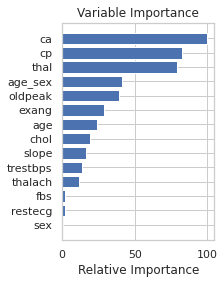

In [ ]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

The scores for this model also show it is a good option.

## Model option 2
Going to take out some of the less correlated features and run again.

In [ ]:
# X = df.loc[:, df.columns != target]
X = df[corr_keepers]
Y = df[target]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

### Logistic regression

In [ ]:
lr = LogisticRegression(solver='liblinear', penalty='l1', random_state=2, max_iter=1000)

In [ ]:
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=2, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
lr_score2 = lr.score(X_test, y_test)
lr_cv_score2 = cross_val_score(lr, X, Y, cv=10)
print(lr_score2)
print(lr_cv_score2)

0.8241758241758241
[0.90322581 0.77419355 0.83870968 0.86666667 0.86666667 0.8
 0.86666667 0.93333333 0.7        0.73333333]


This score is higher too than the last time, but still want to look at the other models.

### KNN

In [ ]:
neighbors = KNeighborsClassifier(n_neighbors=3)
neighbors.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [ ]:
knn_pred2 = neighbors.predict(X_test)
knn_score2 = neighbors.score(X_test, y_test)
knn_cv_score2 = cross_val_score(neighbors,X,Y,cv=10)

print(knn_score2)
print(knn_cv_score2)

0.7692307692307693
[0.74193548 0.64516129 0.70967742 0.7        0.9        0.63333333
 0.7        0.76666667 0.66666667 0.73333333]


[[30 11]
 [10 40]]


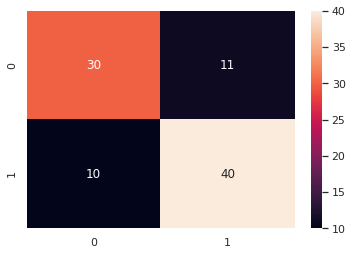

In [ ]:
y_pred = pd.DataFrame(neighbors.predict(X_test))
cm = confusion_matrix(y_test, y_pred)
# print(y_test)
print(cm)
sns.heatmap(cm, annot=True)
plt.show()

This performance is only very slightly better than the last model.

### Decision Tree

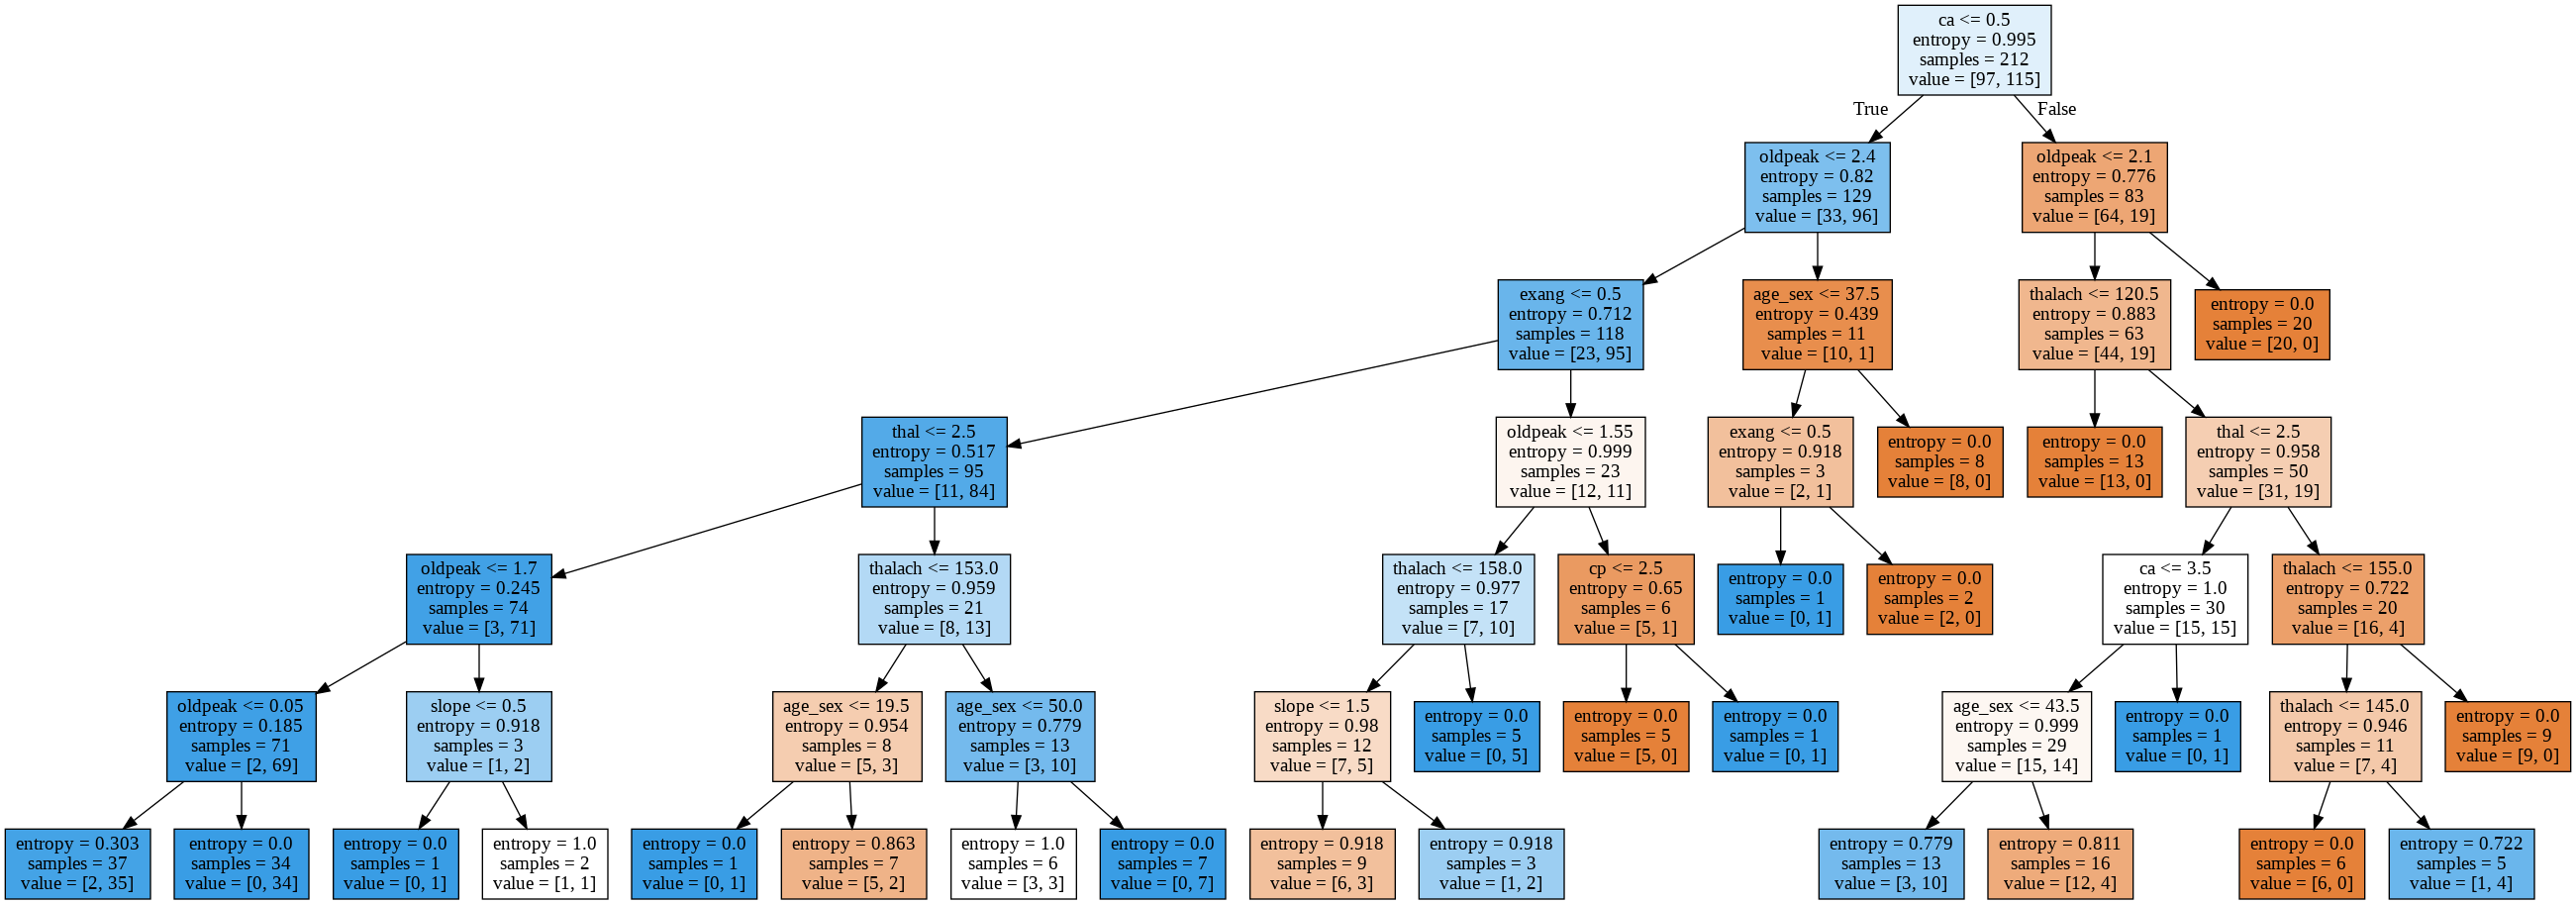

In [ ]:
# This is the model we'll be using.
from sklearn import tree

# A convenience for displaying visualizations.
from IPython.display import Image

# Packages for rendering our tree.
import pydotplus
import graphviz

# Initialize and train our tree.
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=1,
    max_depth=6,
    random_state = 1337
)
decision_tree.fit(X_train, y_train)

# Render our tree.
dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=X.columns,
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [ ]:
feat_importance = decision_tree.tree_.compute_feature_importances(normalize=False)
feat_imp_dict = dict(zip(X.columns, decision_tree.feature_importances_))
feat_imp = pd.DataFrame.from_dict(feat_imp_dict, orient='index')
feat_imp.rename(columns = {0:'FeatureImportance'}, inplace = True)
feat_imp.sort_values(by=['FeatureImportance'], ascending=False).head()

,FeatureImportance
ca,0.281811
oldpeak,0.218940
thalach,0.174412
exang,0.098940
thal,0.097005


In [ ]:
dt_score2 = decision_tree.score(X_test, y_test)
dt_cv_score2 = cross_val_score(decision_tree, X, Y, cv=10)
print(dt_score2)
print(dt_cv_score2)

0.7362637362637363
[0.74193548 0.70967742 0.80645161 0.83333333 0.9        0.66666667
 0.6        0.8        0.73333333 0.86666667]


### Boosting

In [ ]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.

# *** It's best to update this table for the drill 
#  at the end of the lesson.  ***

params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

In [ ]:
def plot_confusion_matrix(cm, classes,normalize,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center", verticalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


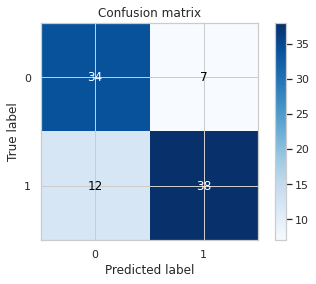

In [ ]:
cm = confusion_matrix(y_test, predict_test)
plot_confusion_matrix(cm,[0,1],False)

Normalized confusion matrix


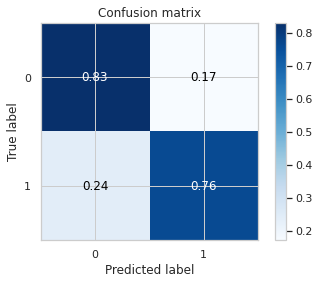

In [ ]:
cm = confusion_matrix(y_test, predict_test)
plot_confusion_matrix(cm,[0,1],True)

In [ ]:
boost_score2 = clf.score(X_test, y_test)
boost_cv_score2 = cross_val_score(clf, X, Y, cv=10)
print(boost_score2)
print(boost_cv_score2)

0.7912087912087912
[0.87096774 0.77419355 0.80645161 0.8        0.83333333 0.73333333
 0.73333333 0.76666667 0.73333333 0.76666667]


In [ ]:
y_pred = clf.predict(X_test)
precision_score(y_test,y_pred)

0.8444444444444444

In [ ]:
recall_score(y_test,y_pred)

0.76

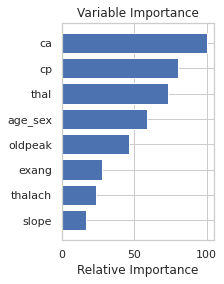

In [ ]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

The first model performed better than this one. However the second logistic regeression outperformed them all. 

# 5. Results

The logistic regression classifier model outperformed all the other models. Taking a look at the scores for each. I'm going to opt to use the logisitc regression model from the second set of data with some of the features removed. Looking at the scores, this model was the highest at 0.824. The score being in this range also does not suggest overfitting. 

In [ ]:
lr_results = pd.DataFrame([[lr_score1, lr_cv_score1],[lr_score2,lr_cv_score2]],columns=['score','cv_score'],index=['lr_model_1', 'lr_model_2'])

In [ ]:
knn_results = pd.DataFrame([[knn_score1, knn_cv_score1],[knn_score2,knn_cv_score2]],columns=['score','cv_score'],index=['knn_model_1', 'knn_model_2'])

In [ ]:
dt_results = pd.DataFrame([[dt_score1, dt_cv_score1],[dt_score2,dt_cv_score2]],columns=['score','cv_score'],index=['dt_model_1', 'dt_model_2'])

In [ ]:
boost_results = pd.DataFrame([[boost_score1, boost_cv_score1],[boost_score2,boost_cv_score2]],columns=['score','cv_score'],index=['boost_model_1', 'boost_model_2'])

In [ ]:
all_results = pd.concat([lr_results, knn_results, dt_results, boost_results])
all_results

,score,cv_score
lr_model_1,0.813187,"[0.8709677419354839, 0.7741935483870968, 0.838..."
lr_model_2,0.824176,"[0.9032258064516129, 0.7741935483870968, 0.838..."
knn_model_1,0.747253,"[0.7741935483870968, 0.6774193548387096, 0.709..."
knn_model_2,0.769231,"[0.7419354838709677, 0.6451612903225806, 0.709..."
dt_model_1,0.725275,"[0.7741935483870968, 0.7096774193548387, 0.741..."
dt_model_2,0.736264,"[0.7419354838709677, 0.7096774193548387, 0.806..."
boost_model_1,0.802198,"[0.7741935483870968, 0.8387096774193549, 0.838..."
boost_model_2,0.791209,"[0.8709677419354839, 0.7741935483870968, 0.806..."


# 6. Discussion and recommendation

The data is somewhat smaller. Ideally the sample set would be a little bit larger to be able to get a better fit. Looking at the CV results, depending on the portion of the data used, the scores seem to oscillate a bit. 